In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src')) # include top level package in python path

In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
.container { 
    width: 100% !important;
}
</style>
"""))

In [3]:
import torch
from torch import nn, Tensor
from model.fuzzy_layer import (
    FuzzySignedConjunction, 
    FuzzySignedDisjunction, 
    FuzzyUnsignedConjunction, 
    FuzzyUnsignedDisjunction, 
    FuzzyNumKeepup, 
    keepidx, 
    fuzzy_dropup
)
from model.fuzzy_logic import ProductLogic, MinimumLogic, LukasiewiczLogic, DrasticLogic, SchweizerSklarLogic
from model.fuzzy_layer import FuzzyParam
from model.bool_logic import BoolLogic
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from util import shuffle

logic = BoolLogic()
flogic = ProductLogic()

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

trainloader = DataLoader(trainset, batch_size=128)
testloader = DataLoader(testset, batch_size=128)

In [5]:
class FuzzyMNIST(nn.Module):
    
    def __init__(self, logic):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            FuzzySignedConjunction(64, 64, logic=logic),
            FuzzyUnsignedDisjunction(64, 64, logic=logic),
            FuzzySignedConjunction(64, 64, logic=logic),
            FuzzyUnsignedDisjunction(64, 10, logic=logic),
            nn.Softmax(dim=-1),
        )
        
    def forward(self, input):
        return self.model(input)

In [6]:
model = FuzzyMNIST(logic=ProductLogic())

In [7]:
def train_loop(model, optim, loader):
    loss_fn = nn.CrossEntropyLoss()
    losses = []
    
    for imgs, labels in loader:
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        losses.append(loss.item())

        optim.zero_grad()
        loss.backward()
        optim.step()

    return torch.Tensor(losses)

In [8]:
def test_loop(model, loader):
    correct_count = 0
    total_count = 0
    
    for imgs, labels in loader:
        preds = model(imgs)
        pred_labels = preds.argmax(dim=-1)
        correct_count += (pred_labels == labels).sum()
        total_count += labels.numel()
        
    return correct_count / total_count

In [9]:
def loop(model, optim, trainloader, testloader, epochs=1):
    losses = torch.zeros(0)
    test_accuracies = []
    
    for epoch_no in range(1, epochs+1):
        train_l = tqdm(trainloader, desc="Epoch #%s, Training" % epoch_no, leave=False)
        new_losses = train_loop(model, optim, train_l)
        losses = torch.cat((losses, new_losses), dim=0)
        
        test_l = tqdm(testloader, desc="Epoch #%s, Testing" % epoch_no, leave=False)
        test_accuracies.append(test_loop(model, test_l))
        
    return losses, torch.Tensor(test_accuracies)

In [10]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
losses, accuracies = loop(model, optim, trainloader, testloader, epochs=500)

Epoch #1, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #1, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #2, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #2, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #3, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #3, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #4, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #4, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #5, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #5, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #6, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #6, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #7, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #7, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #8, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #8, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #9, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #9, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #10, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #10, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #11, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #11, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #12, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #12, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #13, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #13, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #14, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #14, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #15, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #15, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #16, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #16, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #17, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #17, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #18, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #18, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #19, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #19, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #20, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #20, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #21, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #21, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #22, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #22, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #23, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #23, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #24, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #24, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #25, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #25, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #26, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #26, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #27, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #27, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #28, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #28, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #29, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #29, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #30, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #30, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #31, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #31, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #32, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #32, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #33, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #33, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #34, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #34, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #35, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #35, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #36, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #36, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #37, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #37, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #38, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #38, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #39, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #39, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #40, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #40, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #41, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #41, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #42, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #42, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #43, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #43, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #44, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #44, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #45, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #45, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #46, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #46, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #47, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #47, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #48, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #48, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #49, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #49, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #50, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #50, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #51, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #51, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #52, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #52, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #53, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #53, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #54, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #54, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #55, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #55, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #56, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #56, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #57, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #57, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #58, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #58, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #59, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #59, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #60, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #60, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #61, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #61, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #62, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #62, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #63, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #63, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #64, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #64, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #65, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #65, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #66, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #66, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #67, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #67, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #68, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #68, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #69, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #69, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #70, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #70, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #71, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #71, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #72, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #72, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #73, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #73, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #74, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #74, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #75, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #75, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #76, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #76, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #77, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #77, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #78, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #78, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #79, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #79, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #80, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #80, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #81, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #81, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #82, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #82, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #83, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #83, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #84, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #84, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #85, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #85, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #86, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #86, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #87, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #87, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #88, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #88, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #89, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #89, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #90, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #90, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #91, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #91, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #92, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #92, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #93, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #93, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #94, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #94, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #95, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #95, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #96, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #96, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #97, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #97, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #98, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #98, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #99, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #99, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #100, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #100, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #101, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #101, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #102, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #102, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #103, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #103, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #104, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #104, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #105, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #105, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #106, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #106, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #107, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #107, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #108, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #108, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #109, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #109, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #110, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #110, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #111, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #111, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #112, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #112, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #113, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #113, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #114, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #114, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #115, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #115, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #116, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #116, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #117, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #117, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #118, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #118, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #119, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #119, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #120, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #120, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #121, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #121, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #122, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #122, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #123, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #123, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #124, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #124, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #125, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #125, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #126, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #126, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #127, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #127, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #128, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #128, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #129, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #129, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #130, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #130, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #131, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #131, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #132, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #132, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #133, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #133, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #134, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #134, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #135, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #135, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #136, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #136, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #137, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #137, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #138, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #138, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #139, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #139, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #140, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #140, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #141, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #141, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #142, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #142, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #143, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #143, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #144, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #144, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #145, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #145, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #146, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #146, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #147, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #147, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #148, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #148, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #149, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #149, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #150, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #150, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #151, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #151, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #152, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #152, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #153, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #153, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #154, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #154, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #155, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #155, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #156, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #156, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #157, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #157, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #158, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #158, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #159, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #159, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #160, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #160, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #161, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #161, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #162, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #162, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #163, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #163, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #164, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #164, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #165, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #165, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #166, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #166, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #167, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #167, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #168, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #168, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #169, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #169, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #170, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #170, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #171, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #171, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #172, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #172, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #173, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #173, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #174, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #174, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #175, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #175, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #176, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #176, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #177, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #177, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #178, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #178, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #179, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #179, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #180, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #180, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #181, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #181, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #182, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #182, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #183, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #183, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #184, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #184, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #185, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #185, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #186, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #186, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #187, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #187, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #188, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #188, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #189, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #189, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #190, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #190, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #191, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #191, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #192, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #192, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #193, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #193, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #194, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #194, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #195, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #195, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #196, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #196, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #197, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #197, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #198, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #198, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #199, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #199, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #200, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #200, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #201, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #201, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #202, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #202, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #203, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #203, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #204, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #204, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #205, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #205, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #206, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #206, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #207, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #207, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #208, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #208, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #209, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #209, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #210, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #210, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #211, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #211, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #212, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #212, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #213, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #213, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #214, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #214, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #215, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #215, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #216, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #216, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #217, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #217, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #218, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #218, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #219, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #219, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #220, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #220, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #221, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #221, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #222, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #222, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #223, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #223, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #224, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #224, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #225, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #225, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #226, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #226, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #227, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #227, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #228, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #228, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #229, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #229, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #230, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #230, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #231, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #231, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #232, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #232, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #233, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #233, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #234, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #234, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #235, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #235, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #236, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #236, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #237, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #237, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #238, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #238, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #239, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #239, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #240, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #240, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #241, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #241, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #242, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #242, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #243, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #243, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #244, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #244, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #245, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #245, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #246, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #246, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #247, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #247, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #248, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #248, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #249, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #249, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #250, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #250, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #251, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #251, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #252, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #252, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #253, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #253, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #254, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #254, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #255, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #255, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #256, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #256, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #257, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #257, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #258, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #258, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #259, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #259, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #260, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #260, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #261, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #261, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #262, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #262, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #263, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #263, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #264, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #264, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #265, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #265, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #266, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #266, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #267, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #267, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #268, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #268, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #269, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #269, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #270, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #270, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #271, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #271, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #272, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #272, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #273, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #273, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #274, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #274, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #275, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #275, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #276, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #276, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #277, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #277, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #278, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #278, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #279, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #279, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #280, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #280, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #281, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #281, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #282, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #282, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #283, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #283, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #284, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #284, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #285, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #285, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #286, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #286, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #287, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #287, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #288, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #288, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #289, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #289, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #290, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #290, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #291, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #291, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #292, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #292, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #293, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #293, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #294, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #294, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #295, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #295, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #296, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #296, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #297, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #297, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #298, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #298, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #299, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #299, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #300, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #300, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #301, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #301, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #302, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #302, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #303, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #303, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #304, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #304, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #305, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #305, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #306, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #306, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #307, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #307, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #308, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #308, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #309, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #309, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #310, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #310, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #311, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #311, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #312, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #312, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #313, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #313, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #314, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #314, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #315, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #315, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #316, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #316, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #317, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #317, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #318, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #318, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #319, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #319, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #320, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #320, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #321, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #321, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #322, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #322, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #323, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #323, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #324, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #324, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #325, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #325, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #326, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #326, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #327, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #327, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #328, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #328, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #329, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #329, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #330, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #330, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #331, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #331, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #332, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #332, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #333, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #333, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #334, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #334, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #335, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #335, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #336, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #336, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #337, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #337, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #338, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #338, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #339, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #339, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #340, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #340, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #341, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #341, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #342, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #342, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #343, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #343, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #344, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #344, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #345, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #345, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #346, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #346, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #347, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #347, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #348, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #348, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #349, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #349, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #350, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #350, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #351, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #351, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #352, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #352, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #353, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #353, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #354, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #354, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #355, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #355, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #356, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #356, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #357, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #357, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #358, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #358, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #359, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #359, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #360, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #360, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #361, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #361, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #362, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #362, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #363, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #363, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #364, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #364, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #365, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #365, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #366, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #366, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #367, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #367, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #368, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #368, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #369, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #369, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #370, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #370, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #371, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #371, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #372, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #372, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #373, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #373, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #374, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #374, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #375, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #375, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #376, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #376, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #377, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #377, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #378, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #378, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #379, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #379, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #380, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #380, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #381, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #381, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #382, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #382, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #383, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #383, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #384, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #384, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #385, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #385, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #386, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #386, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #387, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #387, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #388, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #388, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #389, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #389, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #390, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #390, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #391, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #391, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #392, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #392, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #393, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #393, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #394, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #394, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #395, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #395, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #396, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #396, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #397, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #397, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #398, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #398, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #399, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #399, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #400, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #400, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #401, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #401, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #402, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #402, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #403, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #403, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #404, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #404, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #405, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #405, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #406, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #406, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #407, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #407, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #408, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #408, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #409, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #409, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #410, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #410, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #411, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #411, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #412, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #412, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #413, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #413, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #414, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #414, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #415, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #415, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #416, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #416, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #417, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #417, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #418, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #418, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #419, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #419, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #420, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #420, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #421, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #421, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #422, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #422, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #423, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #423, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #424, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #424, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #425, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #425, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #426, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #426, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #427, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #427, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #428, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #428, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #429, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #429, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #430, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #430, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #431, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #431, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #432, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #432, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #433, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #433, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #434, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #434, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #435, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #435, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #436, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #436, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #437, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #437, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #438, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #438, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #439, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #439, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #440, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #440, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #441, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #441, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #442, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #442, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #443, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #443, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #444, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #444, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #445, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #445, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #446, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #446, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #447, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #447, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #448, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #448, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #449, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #449, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #450, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #450, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #451, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #451, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #452, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #452, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #453, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #453, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #454, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #454, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #455, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #455, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #456, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #456, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #457, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #457, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #458, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #458, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #459, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #459, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #460, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #460, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #461, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #461, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #462, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #462, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #463, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #463, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #464, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #464, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #465, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #465, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #466, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #466, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #467, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #467, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #468, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #468, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #469, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #469, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #470, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #470, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #471, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #471, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #472, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #472, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #473, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #473, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #474, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #474, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #475, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #475, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #476, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #476, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #477, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #477, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #478, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #478, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #479, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #479, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #480, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #480, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #481, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #481, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #482, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #482, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #483, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #483, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #484, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #484, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #485, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #485, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #486, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #486, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #487, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #487, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #488, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #488, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #489, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #489, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #490, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #490, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #491, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #491, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #492, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #492, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #493, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #493, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #494, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #494, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #495, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #495, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #496, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #496, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #497, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #497, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #498, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #498, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #499, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #499, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch #500, Training:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch #500, Testing:   0%|          | 0/79 [00:00<?, ?it/s]

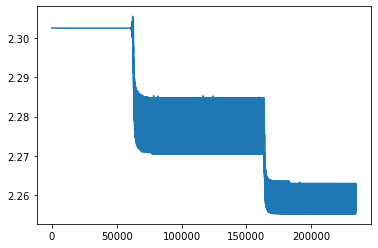

In [12]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [13]:
torch.rand(3,4).argmax(dim=-1)

tensor([1, 1, 3])

In [14]:
accuracies

tensor([0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135,
        0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135,
        0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135,
        0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135, 0.1135,
        0.1135, 0.1135, 0.1135, 0.1135, 